#      **Ageing Signs Detection : A Deep Learning Solution**

# Setup

### Install Dependancies

In [2]:
#!pip install -U --pre tensorflow=="2.*"
#!pip install tf_slim

In [3]:
#!pip install tensorflow-object-detection-api

In [4]:
#!pip install pycocotools

### Imports

In [5]:
import tensorflow as tf
print(tf.__version__)


2.9.1


In [6]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#import tensorflow as tf

In [7]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
#import tensorflow as tf
import zipfile

In [8]:
#import tensorflow as tf

In [9]:
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [10]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## *Apply Patches*

In [26]:
utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

In [27]:
PATH_TO_LABELS = 'object_detection/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# *Model preparation*

In [28]:
import pathlib
# If you want to test the code with your images, just add images to the test_images folder.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.*")))

In [29]:
detection_model = tf.saved_model.load('object_detection/saved_model')

In [30]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=resource>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=resource>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=resource>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=resource>, <tf.Tensor 'unknown_7:0' shape=() dtype=resource>, <tf.Tensor 'unknown_8:0' shape=() dtype=resource>, <tf.Tensor 'unknown_9:0' shape=() dtype=resource>, <tf.Tensor 'unknown_10:0' shape=() dtype=resource>, <tf.Tensor 'unknown_11:0' shape=() dtype=resource>, <tf.Tensor 'unknown_12:0' shape=() dtype=resource>, <tf.Tensor 'unknown_13:0' shape=() dtype=resource>, <tf.Tensor 'unknown_14:0' shape=() dtype=resource>, <tf.Tensor 'unknown_15:0' shape=() dtype=resource>, <tf.Tensor 'unknown_16:0' shape=() dtype=resource>, <tf.Tenso

In [31]:
detection_model.signatures['serving_default'].output_dtypes

{'detection_scores': tf.float32,
 'detection_boxes': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_anchor_indices': tf.float32,
 'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'raw_detection_boxes': tf.float32}

In [32]:
detection_model.signatures['serving_default'].output_shapes

{'detection_scores': TensorShape([1, 100]),
 'detection_boxes': TensorShape([1, 100, 4]),
 'raw_detection_scores': TensorShape([1, 49104, 3]),
 'detection_anchor_indices': TensorShape([1, 100]),
 'detection_classes': TensorShape([1, 100]),
 'num_detections': TensorShape([1]),
 'detection_multiclass_scores': TensorShape([1, 100, 3]),
 'raw_detection_boxes': TensorShape([1, 49104, 4])}

In [33]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                   for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [34]:
def show_inference(model, image_path):
    image_np = np.array(Image.open(image_path))
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8)
    display(Image.fromarray(image_np))

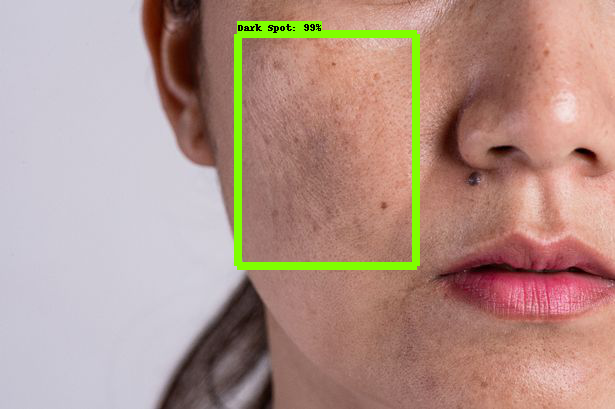

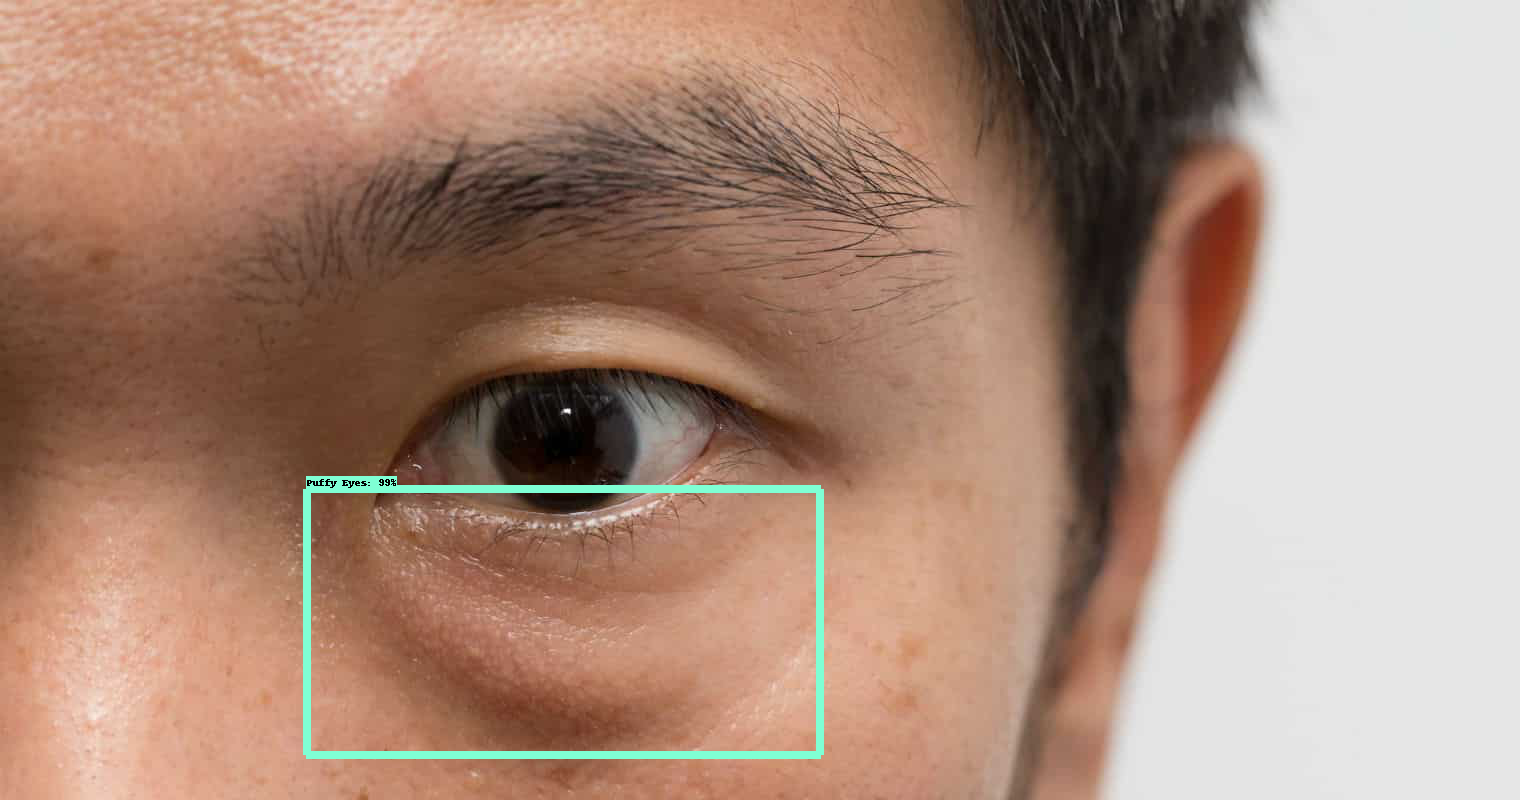

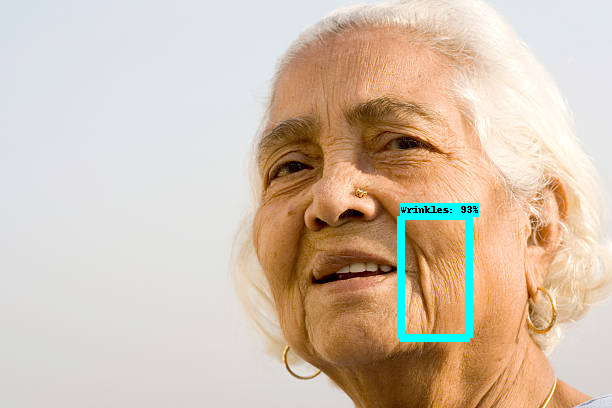

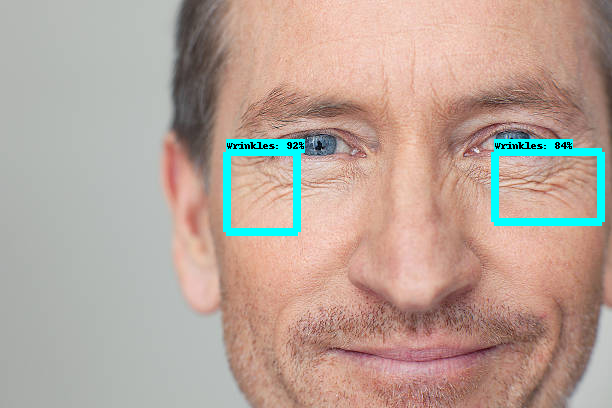

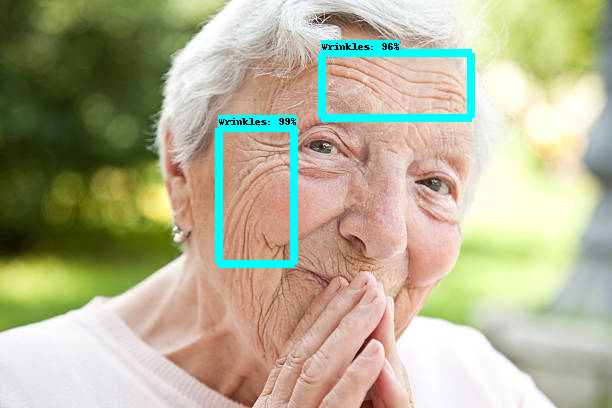

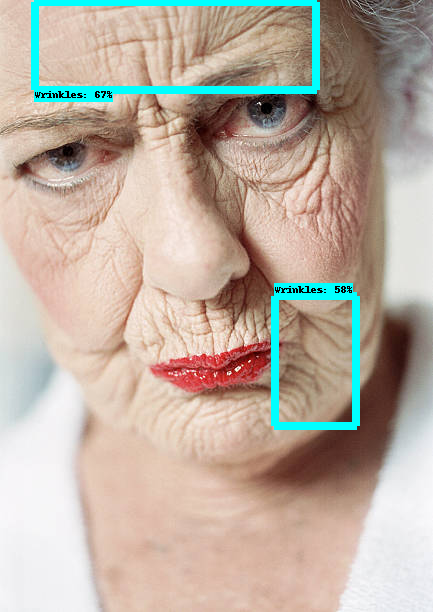

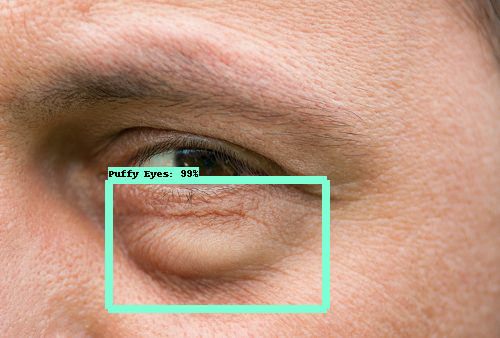

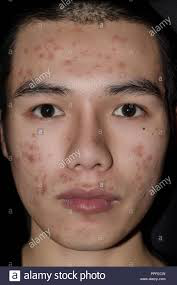

In [35]:
for image_path in TEST_IMAGE_PATHS:
    show_inference(detection_model, image_path)